In [2]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
img_height, img_width = (244,244)
batch_size = 32

train_data_dir = r"/content/drive/MyDrive/BrainTumor/Otsu/Training"
valid_data_dir = r"/content/drive/MyDrive/BrainTumor/Otsu/Testing"
test_data_dir = r"/content/drive/MyDrive/BrainTumor/Otsu/Testing"

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, shear_range=0.2,zoom_range=0.2,horizontal_flip=True, validation_split=0.4)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

valid_generator = train_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height,img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 1722 images belonging to 4 classes.
Found 158 images belonging to 4 classes.


In [5]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation')

Found 158 images belonging to 4 classes.


In [6]:
x,y = test_generator.next()
x.shape

(1, 244, 244, 3)

In [8]:
base_model = ResNet50(include_top=False, weights = 'imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False

model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(train_generator, epochs = 10)

Epoch 1/10
54/54 [==============================] - 39s 651ms/step - loss: 1.4277 - accuracy: 0.5854
Epoch 2/10
54/54 [==============================] - 35s 648ms/step - loss: 0.6441 - accuracy: 0.7433
Epoch 3/10
54/54 [==============================] - 35s 650ms/step - loss: 0.5597 - accuracy: 0.7811
Epoch 4/10
54/54 [==============================] - 35s 645ms/step - loss: 0.5269 - accuracy: 0.7880
Epoch 5/10
54/54 [==============================] - 35s 647ms/step - loss: 0.5442 - accuracy: 0.7863
Epoch 6/10
54/54 [==============================] - 35s 647ms/step - loss: 0.5070 - accuracy: 0.8066
Epoch 7/10
54/54 [==============================] - 35s 647ms/step - loss: 0.4224 - accuracy: 0.8333
Epoch 8/10
54/54 [==============================] - 36s 656ms/step - loss: 0.4850 - accuracy: 0.8118
Epoch 9/10
54/54 [==============================] - 35s 645ms/step - loss: 0.4233 - accuracy: 0.8298
Epoch 10/10
54/54 [==============================] - 35s 645ms/step - loss: 0.3547 - accura

In [15]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

158/158 - 5s - loss: 3.4656 - accuracy: 0.3671 - 5s/epoch - 29ms/step


In [10]:
model.save("/content/save.h5")

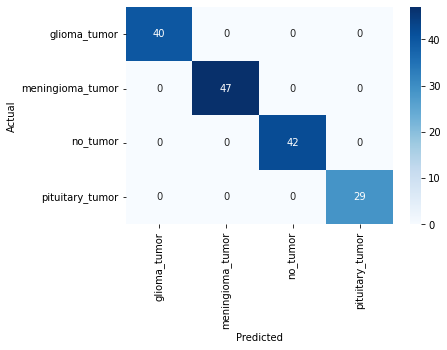

test accuracy : ()


In [11]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model("/content/save.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(Y_test)
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'],colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('test accuracy : ()'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))